## K-Means聚类（2019.7.12 Workshop）

- 时间16:00\-17:00，地点26楼【西语言】会议室
- 内容与形式
    - 30-40分钟简介K-Means聚类的算法原理与工作中的实际项目应用
        - 图片压缩与分割（也可用于主要颜色提取）
        - 文章与关键词聚类
    - 20-30分钟大家自己写代码进行实践，以及问题讨论
- 所需环境与工具
    - 环境：Python3, Jupyter Notebook
    - 工具包：numpy, sklearn, matplotlib, ipywidgets   
- 小提示：带电脑，提前配置环境与工具包

### 适用条件
- 无监督学习：数据没有标注
- 不适用于数据量过高（百万量级以内）
- 不是所有的数据分布情况都适用

###  算法原理
- 随机初始化聚类中心
- 迭代计算
    - 根据距离最近的聚类中心点标注数据
    - 计算新的聚类中心点
- 当聚类数据收敛时，结束迭代
- 评估结果并验证最优K值
    - 肘部方法(Elbow Method)

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from ipywidgets import interact, widgets
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')

### 随机生成Demo数据

(1000, 2)


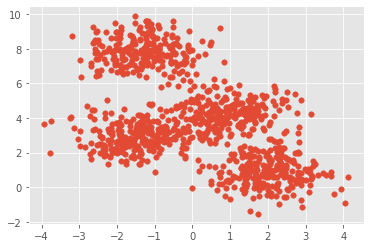

In [3]:
X, y_true = make_blobs(n_samples=1000, centers=4, cluster_std=0.80, random_state=0)
print(X.shape)
plt.scatter(X[:, 0], X[:, 1], s=30);

###  直接从`scikit-learn`调包进行聚类

[[-1.49625761  2.92287009]
 [-1.28504116  7.84558659]
 [ 1.99547655  0.85240748]
 [ 0.95633256  4.27076343]]


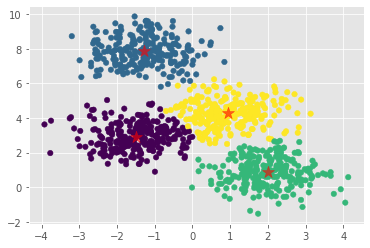

In [4]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_
print(centers)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='*', s=160, alpha=0.6);

In [5]:
kmeans.score(X)

-1178.3603153278104

#### 使用肘部方法确定最优K值

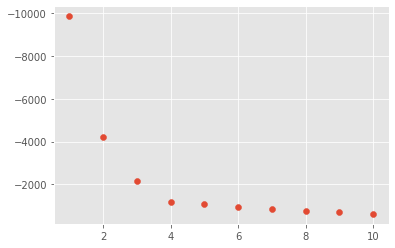

In [6]:
K_max = 10
KM_models = [KMeans(n_clusters=i+1).fit(X) for i in range(K_max)]
scores = [KM_models[i].score(X) for i in range(K_max)]
plt.gca().invert_yaxis()
plt.scatter(np.linspace(1,K_max,K_max), scores)

In [7]:
def find_clusters(X, n_clusters, n_iter=100, rseed=2):
    rng = np.random.RandomState(rseed)

    # 随机初始化聚类中心点（从训练数据中随机选k个作为初始聚类中心）
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    for i in range(n_iter):
        # 根据距离最近的聚类中心点标注数据
        labels = pairwise_distances_argmin(X, centers)

        # 计算新的聚类中心点
        new_centers = np.array(
            [X[labels == i].mean(0) for i in range(n_clusters)]
        )

        # 当聚类数据收敛（聚类中心不再变化）时，结束迭代
        if np.all(centers == new_centers):
            print('Converged after %s iterations.' %i)
            break

        # 更新聚类中心
        centers = new_centers
    return centers, labels

In [8]:
def interact_kmeans(n_clusters=4, n_iter=1, rseed=2, print_centers=False):
    global X
    centers, labels = find_clusters(X, n_clusters, n_iter=n_iter, rseed=rseed)
    plt.figure(figsize=(16,10))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=80, cmap='viridis');
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='*', s=1000, alpha=0.7);
    plt.show()
    if print_centers:
        print(centers)

In [9]:
interact(
    interact_kmeans,
    n_clusters=widgets.IntSlider(min=1, max=10, step=1, value=4, continuous_update=False),
    n_iter=widgets.IntText(value=1),
    rseed=widgets.IntText(value=3),
    print_centers=widgets.Checkbox()
);

interactive(children=(IntSlider(value=4, continuous_update=False, description='n_clusters', max=10, min=1), In…

### K-Means方法压缩图片

(427, 640, 3)


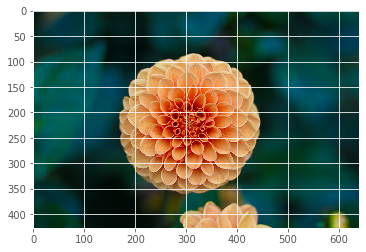

In [10]:
flower = load_sample_image("flower.jpg")
plt.imshow(flower)
print(flower.shape)

In [11]:
print(flower.shape)
flower = np.array(flower, dtype=np.float64) / 255  # 把RGB值映射到[0, 1]区间
print(flower.shape)
w, h, d = original_shape = tuple(flower.shape)
image_array = np.reshape(flower, (w * h, d))  # 展开所有像素

(427, 640, 3)
(427, 640, 3)


In [12]:
def plot_image(img, title, ax=plt):
    ax.imshow(img)
    ax.title.set_text(title)

In [13]:
def recreate_image(img_array, labels, w, h):
    """把展开的像素点重新组合为图片"""
#     d = img_array.shape[1]  # 颜色通道数
    image = np.zeros((w, h, 3))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = img_array[labels[label_idx]]
            label_idx += 1
    return image

In [14]:
def image_compression(n_colors=4, n_samples=1000):
    global image_array
    image_array_sample = shuffle(image_array, random_state=0)[:n_samples]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    img_compressed = recreate_image(kmeans.cluster_centers_, labels, w, h)
    fig, ax = plt.subplots(1,2, figsize=(16,6));
    plot_image(flower, 'Original', ax[0])
    plot_image(img_compressed, 'K-Means', ax[1])

In [15]:
interact(
    image_compression,
    n_colors=widgets.IntText(value=4),
    n_samples=widgets.IntText(value=1000)
);

interactive(children=(IntText(value=4, description='n_colors'), IntText(value=1000, description='n_samples'), …

## Worshop Session & Discussion
- Session1:
重构`find_clusters`方法，使其可读性更高，或更加robust（主要是在这个过程中真正理解K-Means聚类算法）
- Session2:
任选一张图片，对其进行K-Means颜色压缩